#### Benchmaking Experiment 004
- Model : Model4
- Dataset : PAMAP2
- Semantic Space : Glove50
- Cross Validation : 5-fold fixed classes
- Feature Loss : MSELoss

In [1]:
import os 
from datetime import date
from tqdm import tqdm
from copy import deepcopy
import numpy as np 
import pandas as pd

import torch 
from torch import nn, Tensor
from torch.nn import functional as F
from torch.nn.modules import MultiheadAttention, Linear, Dropout, BatchNorm1d, TransformerEncoderLayer
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.nn import MSELoss

from src.datasets.data import PAMAP2Reader
from src.datasets.dataset import PAMAP2Dataset
from src.datasets.utils import load_attribute

from src.models.ts_transformer import TSTransformerEncoderClassiregressor, RelativeGlobalAttention
from src.models.loss import FeatureLoss, AttributeLoss 

from src.utils.analysis import action_evaluator
from src.running import train_step, eval_step

In [2]:
# setup model configurations
config = {
    # general information
    "experiment-name": "test-001", 
    "datetime": date.today(),
    "device": "gpu",
    "dataset": "PAMAP2",
    "Model": "RelativeGlobalAttention",
    "sem-space": "word2vec-v1",
    # model training configs
    "include_attribute_loss": True, 
    "semantic_size": 64,
    "n_actions": 18,
    "folding": True,
    "fold_classes": [['watching TV', 'house cleaning', 'standing', 'ascending stairs'], ['walking', 'rope jumping', 'sitting', 'descending stairs'], ['playing soccer', 'lying', 'vacuum cleaning', 'computer work'], ['cycling', 'running', 'Nordic walking'], ['ironing', 'car driving', 'folding laundry']],
    "lr": 0.001,
    "n_epochs": 10,
    "optimizer": "adam",
    "batch_size": 32,
    "semantic_loss": "cosine_distance",
    # model configs
    "d_model": 128, 
    "num_heads": 2,
    # dataset configs
    "window_size": 5, 
    "overlap": 0.5,
    "seq_len": 200,
    "seen_split": 0.2,
    "unseen_split": 0.8
}

---
Model Building

In [3]:
class Model6(nn.Module):
    def __init__(self, in_ft, d_model, num_heads, ft_size, max_len=1024, dropout=0.1):
        super(Model6, self).__init__()
        self.in_ft = in_ft
        self.max_len = max_len
        self.d_model = d_model
        self.num_heads = num_heads
        self.ft_size = ft_size 

        # feature prep layer
        self.DenseL = nn.Linear(in_ft, d_model)
        # relative global attention layer
        self.AttnL = RelativeGlobalAttention(self.d_model, self.num_heads, self.max_len)
        # positional encoding concat <-> 1DConv 
        self.Act = F.relu#_get_activation_fn(activation)
        self.AvgPoolL = nn.AvgPool2d((self.max_len,1))
        self.DenseL2 = nn.Linear(self.d_model, self.ft_size)
        self.dropout = nn.Dropout1d(dropout)

    def forward(self, x):
        out = self.DenseL(x)
        out = self.AttnL(out)
        out = self.Act(out)
        out = self.AvgPoolL(out)
        out = torch.squeeze(out)
        out = self.dropout(out)
        out = self.DenseL2(out)        
        return out

---

In [4]:
if config['device'] == 'cpu':
    device = "cpu"
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# import PAMAP2 dataset
dataReader = PAMAP2Reader('./data/PAMAP2_Dataset/Protocol/')
actionList = dataReader.idToLabel

Reading file 1 of 14
Reading file 2 of 14
Reading file 3 of 14
Reading file 4 of 14
Reading file 5 of 14
Reading file 6 of 14
Reading file 7 of 14
Reading file 8 of 14
Reading file 9 of 14
Reading file 10 of 14
Reading file 11 of 14
Reading file 12 of 14
Reading file 13 of 14
Reading file 14 of 14


g:\FYP\Codebases\HAR-ZSL-XAI\src\datasets\data.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.asarray(data), np.asarray(labels, dtype=int), np.array(collection)


In [6]:
# import PAMAP2 attributes
activity_dict, attribute_dict, attr_mat = load_attribute('./data/PAMAP2_Dataset/PAMAP2_attributes.json')
_, attr_size = attr_mat.shape

In [7]:
# Load semantic feature space 
st = config['sem-space']
if st == 'glove50-v1':
    fpath = './data/PAMAP2_Dataset/glove_features.npy'
elif st == 'glove50-v2':
    fpath = './data/PAMAP2_Dataset/glove_featureV2.npy'
elif st == 'video-V1':
    fpath = './data/PAMAP2_Dataset/video_pca_ft.npy'
elif st == 'word2vec-v1':
    fpath = './data/PAMAP2_Dataset/word2vec_features.npy'
elif st == 'word2vec-v2':
    fpath = './data/PAMAP2_Dataset/word2vec_featureV2.npy'

feat_mat = np.load(fpath)
n_actions, feat_size = feat_mat.shape

In [8]:
# run 5-fold running
fold_classes = config['fold_classes']
fold_cls_ids = [[actionList.index(i) for i in j] for j in fold_classes]

================ Fold-0 ================
Unseen Classes : ['watching TV', 'house cleaning', 'standing', 'ascending stairs']


eval: 100%|██████████| 26/26 [00:00<00:00, 60.18batch/s, loss=0.0267]


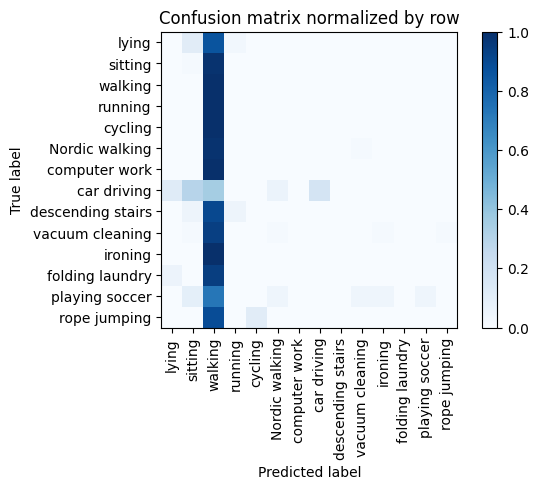

Training Epoch:  10%|█         | 1/10 [00:10<01:34, 10.52s/it]

Overall accuracy: 0.121



eval: 100%|██████████| 26/26 [00:00<00:00, 65.33batch/s, loss=0.0218]


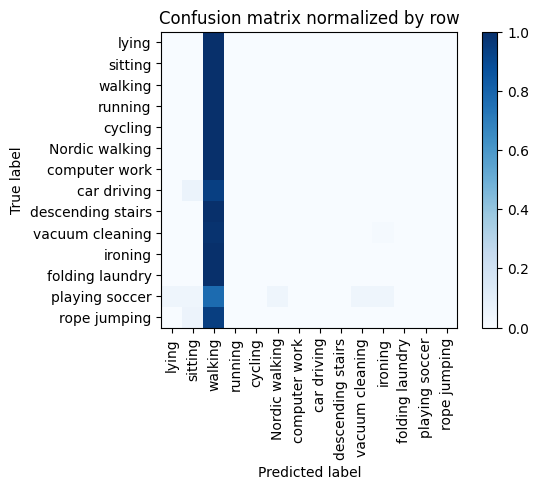

Training Epoch:  20%|██        | 2/10 [00:13<00:50,  6.33s/it]

Overall accuracy: 0.115



eval: 100%|██████████| 26/26 [00:00<00:00, 62.27batch/s, loss=0.0192]


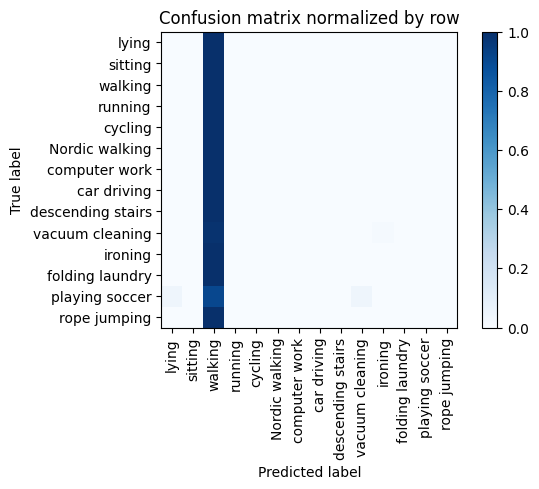

Training Epoch:  30%|███       | 3/10 [00:17<00:34,  4.93s/it]

Overall accuracy: 0.115



eval: 100%|██████████| 26/26 [00:00<00:00, 64.92batch/s, loss=0.0174]


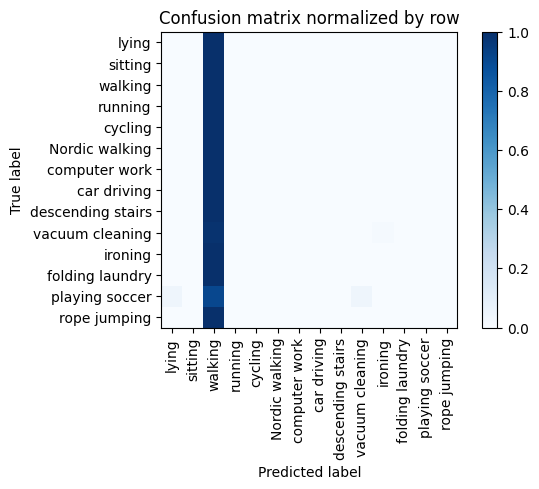

Training Epoch:  40%|████      | 4/10 [00:20<00:25,  4.33s/it]

Overall accuracy: 0.115



eval: 100%|██████████| 26/26 [00:00<00:00, 64.08batch/s, loss=0.0227]


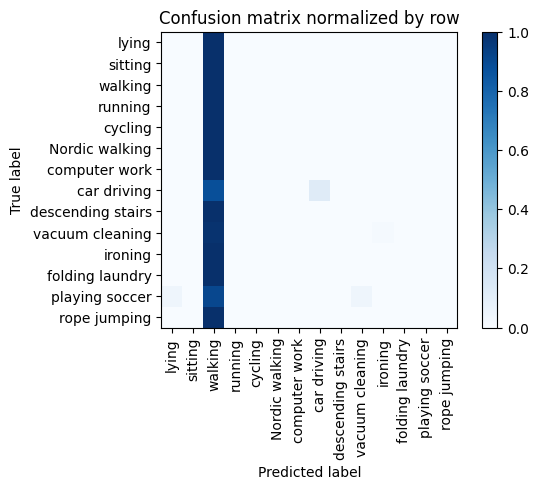

Training Epoch:  50%|█████     | 5/10 [00:23<00:19,  3.96s/it]

Overall accuracy: 0.118



eval: 100%|██████████| 26/26 [00:00<00:00, 44.02batch/s, loss=0.0223]


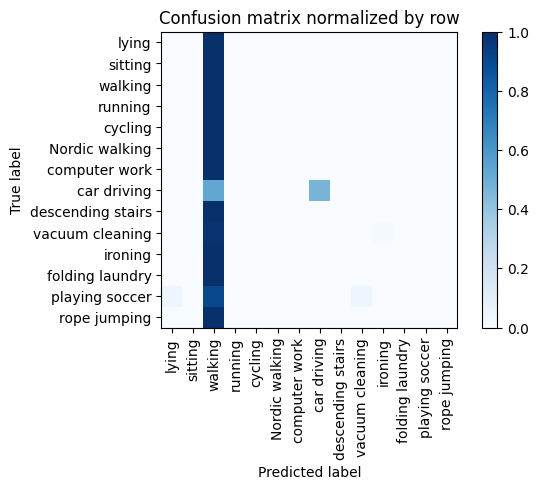

Training Epoch:  60%|██████    | 6/10 [00:28<00:16,  4.13s/it]

Overall accuracy: 0.125



eval: 100%|██████████| 26/26 [00:00<00:00, 61.61batch/s, loss=0.0221]


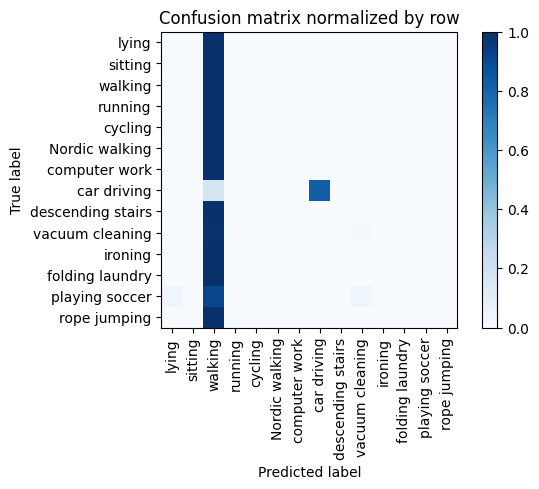

Training Epoch:  70%|███████   | 7/10 [00:31<00:11,  3.86s/it]

Overall accuracy: 0.134



eval: 100%|██████████| 26/26 [00:00<00:00, 58.76batch/s, loss=0.0203]


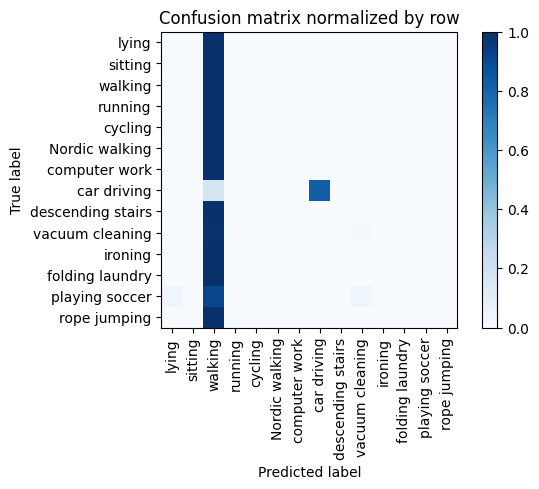

Training Epoch:  80%|████████  | 8/10 [00:35<00:07,  3.70s/it]

Overall accuracy: 0.134



eval: 100%|██████████| 26/26 [00:00<00:00, 61.96batch/s, loss=0.0222]


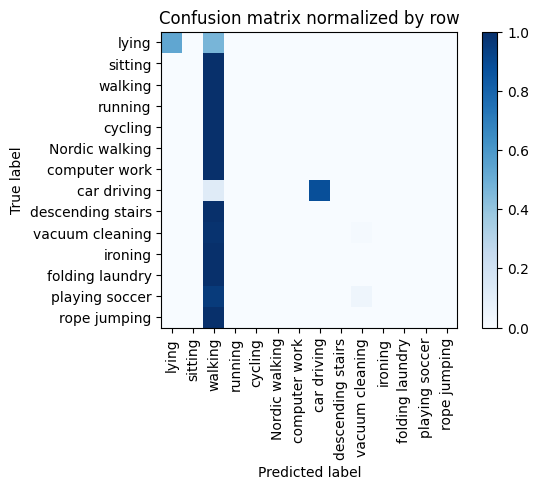

Training Epoch:  90%|█████████ | 9/10 [00:38<00:03,  3.62s/it]

Overall accuracy: 0.183



eval: 100%|██████████| 26/26 [00:00<00:00, 60.11batch/s, loss=0.0265]


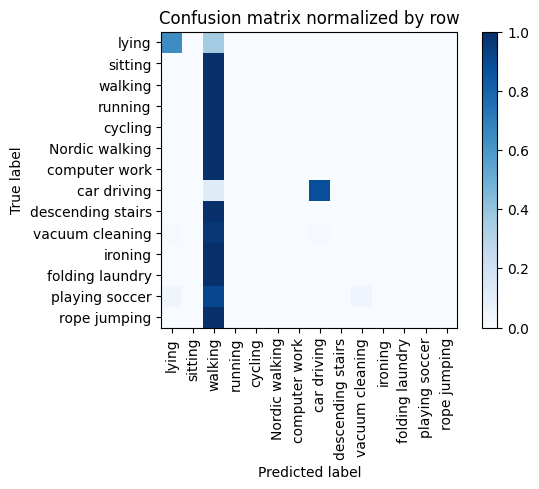

Overall accuracy: 0.191



eval: 100%|██████████| 28/28 [00:00<00:00, 101.45batch/s, loss=0.0196]


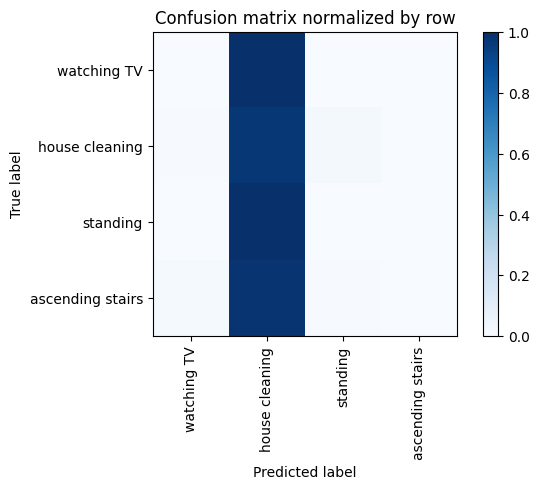

Overall accuracy: 0.316

                   precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        standing       0.000      0.000      0.000      0.337        295|	 house cleaning: 1.000,	ascending stairs: 0.000,	
  house cleaning       0.320      0.972      0.482      0.325        285|	 standing: 0.021,	watching TV: 0.007,	
ascending stairs       0.000      0.000      0.000      0.189        166|	 house cleaning: 0.982,	watching TV: 0.012,	standing: 0.006,	
     watching TV       0.000      0.000      0.000      0.148        130|	 house cleaning: 1.000,	ascending stairs: 0.000,	standing: 0.000,	

----------------------------------------------------------------------------------------------------
     avg / total       0.104      0.316      0.157        1.0        876|	      

{'total_accuracy': 0.3162100456621005, 'precision': 0.0800578034682081, 'recall': 0.24298245614035088, 'f1': 0.12043478260869565}
================ Fold-1 ================
Unseen Classes

eval: 100%|██████████| 26/26 [00:00<00:00, 33.56batch/s, loss=0.0259]


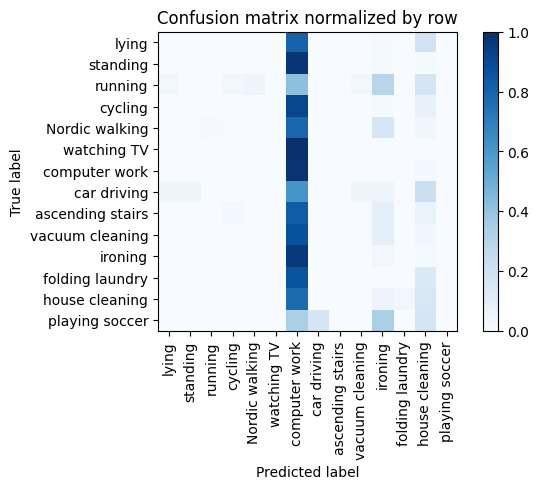

Training Epoch:  10%|█         | 1/10 [00:05<00:45,  5.10s/it]

Overall accuracy: 0.151



eval: 100%|██████████| 26/26 [00:00<00:00, 59.09batch/s, loss=0.025]


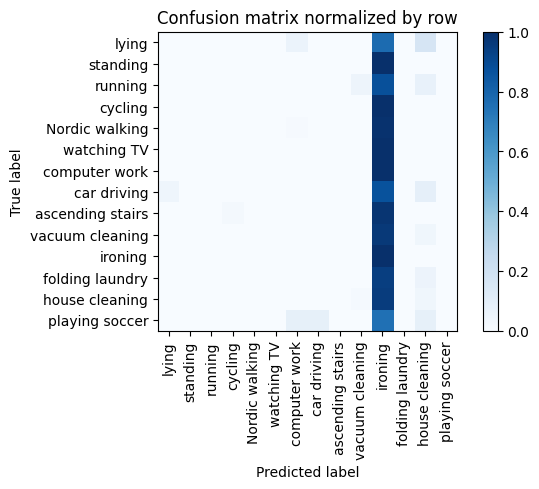

Training Epoch:  20%|██        | 2/10 [00:08<00:34,  4.27s/it]

Overall accuracy: 0.100



eval: 100%|██████████| 26/26 [00:00<00:00, 61.52batch/s, loss=0.0232]


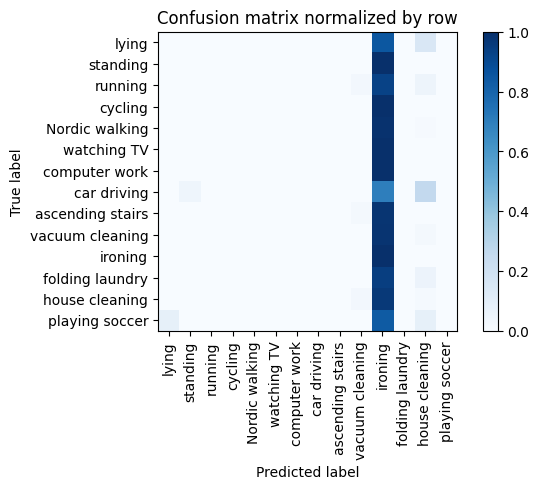

Training Epoch:  30%|███       | 3/10 [00:12<00:27,  3.91s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 26/26 [00:00<00:00, 64.52batch/s, loss=0.0204]


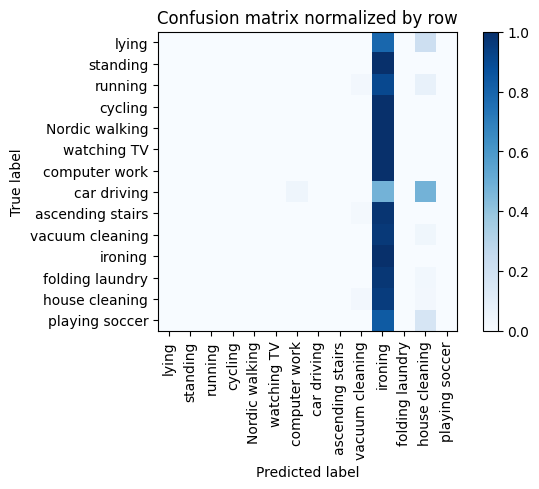

Training Epoch:  40%|████      | 4/10 [00:15<00:22,  3.68s/it]

Overall accuracy: 0.099



eval: 100%|██████████| 26/26 [00:00<00:00, 62.65batch/s, loss=0.0201]


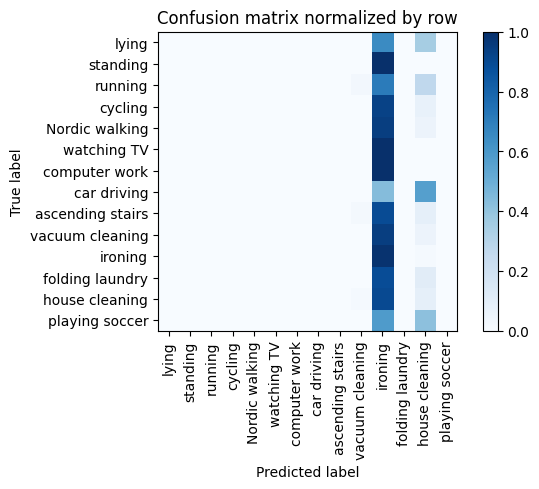

Training Epoch:  50%|█████     | 5/10 [00:19<00:17,  3.59s/it]

Overall accuracy: 0.104



eval: 100%|██████████| 26/26 [00:00<00:00, 35.57batch/s, loss=0.0209]


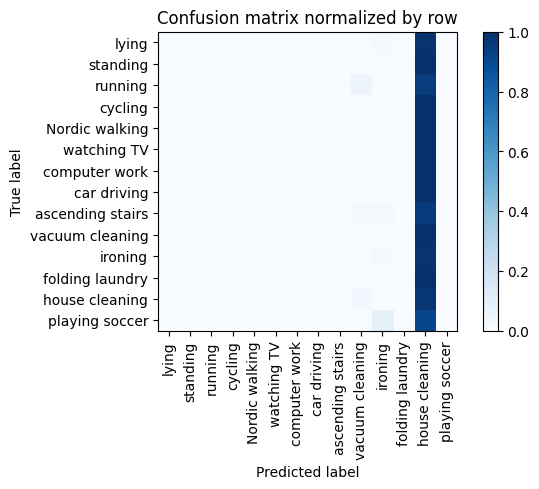

Training Epoch:  60%|██████    | 6/10 [00:23<00:15,  3.82s/it]

Overall accuracy: 0.096



eval: 100%|██████████| 26/26 [00:00<00:00, 62.05batch/s, loss=0.0187]


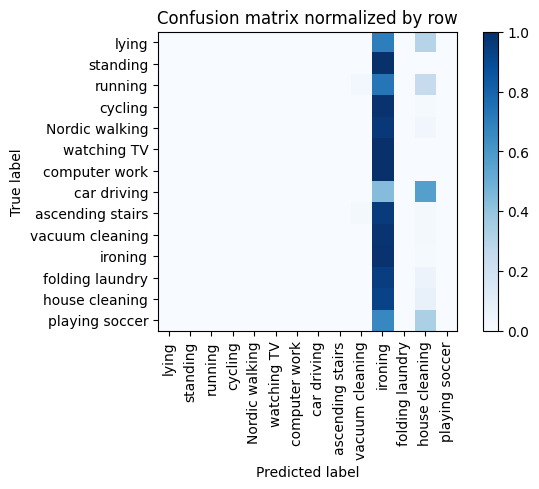

Training Epoch:  70%|███████   | 7/10 [00:26<00:11,  3.70s/it]

Overall accuracy: 0.103



eval: 100%|██████████| 26/26 [00:00<00:00, 64.27batch/s, loss=0.0218]


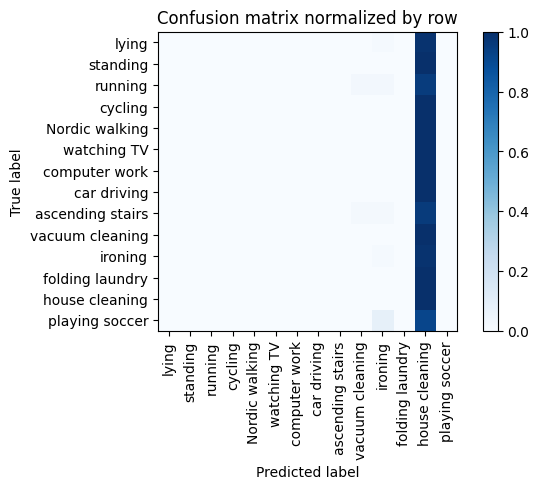

Training Epoch:  80%|████████  | 8/10 [00:30<00:07,  3.63s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 26/26 [00:00<00:00, 65.16batch/s, loss=0.0214]


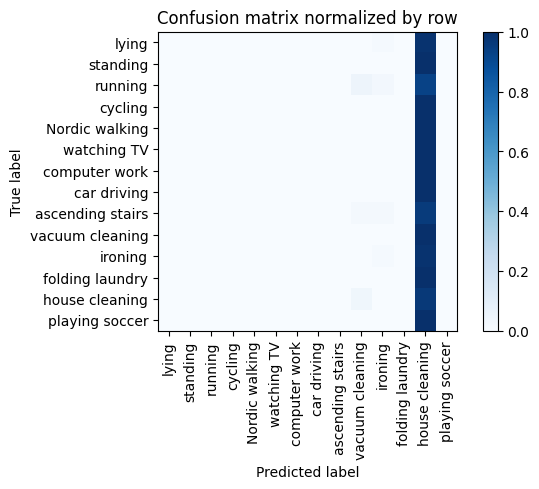

Training Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.55s/it]

Overall accuracy: 0.094



eval: 100%|██████████| 26/26 [00:00<00:00, 62.32batch/s, loss=0.0214]


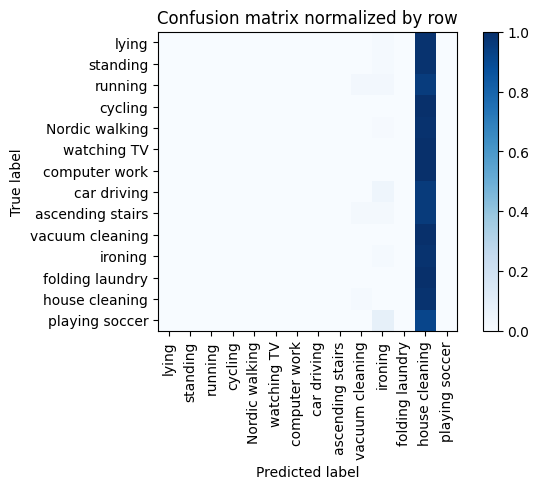

Overall accuracy: 0.097



eval: 100%|██████████| 28/28 [00:00<00:00, 108.11batch/s, loss=0.018] 


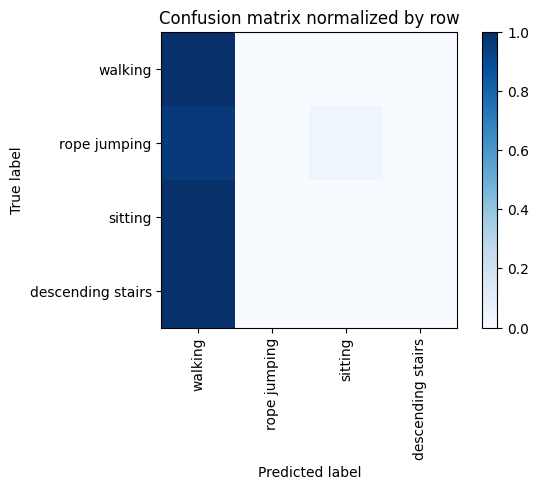

Overall accuracy: 0.423

                    precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

          walking       0.424      1.000      0.596      0.423        369|	 descending stairs: 0.000,	sitting: 0.000,	
          sitting       0.000      0.000      0.000      0.315        275|	 walking: 1.000,	descending stairs: 0.000,	
descending stairs       0.000      0.000      0.000      0.179        156|	 walking: 1.000,	sitting: 0.000,	
     rope jumping       0.000      0.000      0.000      0.084         73|	 walking: 0.959,	sitting: 0.041,	descending stairs: 0.000,	

----------------------------------------------------------------------------------------------------
      avg / total       0.179      0.423      0.252        1.0        873|	      

{'total_accuracy': 0.422680412371134, 'precision': 0.1060344827586207, 'recall': 0.25, 'f1': 0.14891041162227603}
================ Fold-2 ================
Unseen Classes : ['playing soccer', 'lying', 'vacuum cleanin

eval: 100%|██████████| 24/24 [00:00<00:00, 63.83batch/s, loss=0.0307]


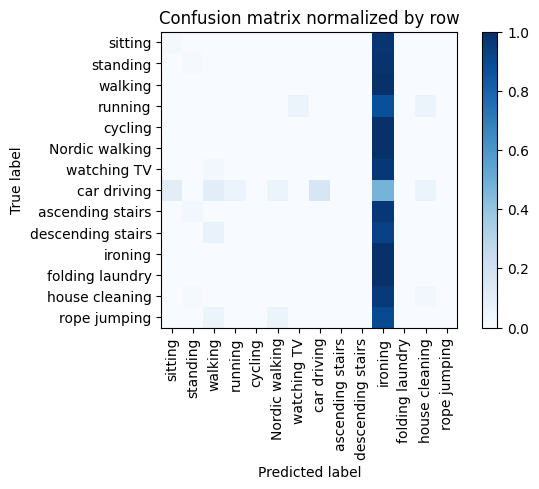

Training Epoch:  10%|█         | 1/10 [00:03<00:28,  3.21s/it]

Overall accuracy: 0.127



eval: 100%|██████████| 24/24 [00:00<00:00, 62.99batch/s, loss=0.0213]


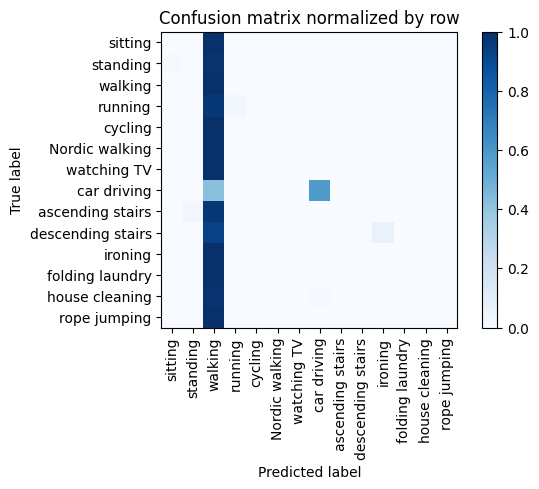

Training Epoch:  20%|██        | 2/10 [00:06<00:25,  3.19s/it]

Overall accuracy: 0.153



eval: 100%|██████████| 24/24 [00:00<00:00, 59.41batch/s, loss=0.0196]


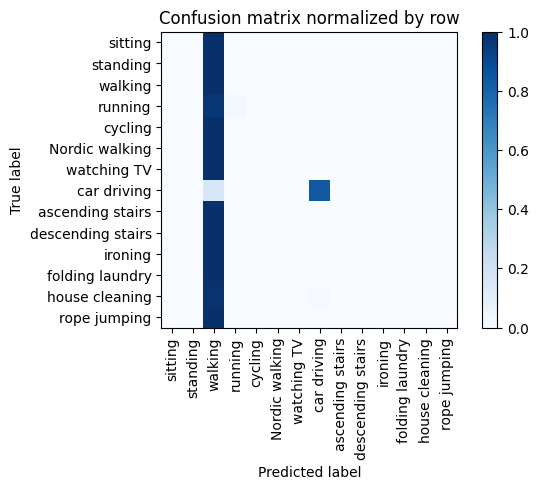

Training Epoch:  30%|███       | 3/10 [00:09<00:22,  3.16s/it]

Overall accuracy: 0.160



eval: 100%|██████████| 24/24 [00:00<00:00, 60.61batch/s, loss=0.0213]


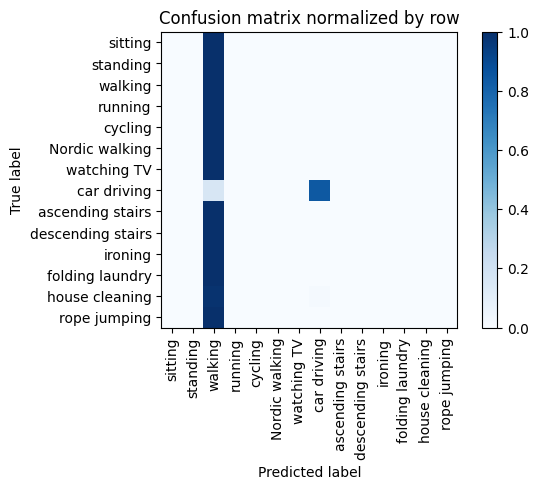

Training Epoch:  40%|████      | 4/10 [00:12<00:19,  3.17s/it]

Overall accuracy: 0.158



eval: 100%|██████████| 24/24 [00:00<00:00, 63.66batch/s, loss=0.0186]


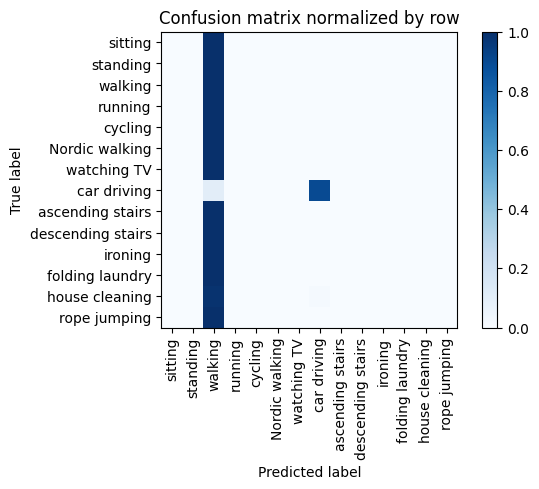

Training Epoch:  50%|█████     | 5/10 [00:16<00:16,  3.23s/it]

Overall accuracy: 0.160



eval: 100%|██████████| 24/24 [00:00<00:00, 54.73batch/s, loss=0.0184]


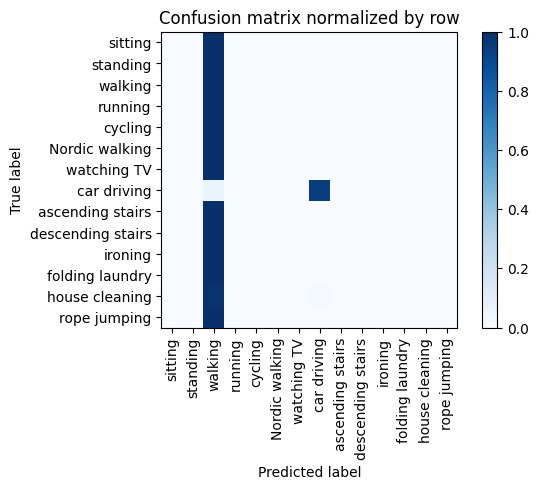

Training Epoch:  60%|██████    | 6/10 [00:19<00:13,  3.27s/it]

Overall accuracy: 0.161



eval: 100%|██████████| 24/24 [00:00<00:00, 64.51batch/s, loss=0.0186]


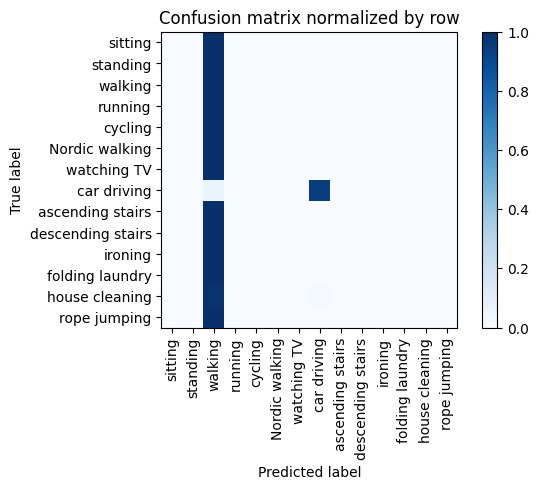

Training Epoch:  70%|███████   | 7/10 [00:22<00:09,  3.24s/it]

Overall accuracy: 0.161



eval: 100%|██████████| 24/24 [00:00<00:00, 62.09batch/s, loss=0.0169]


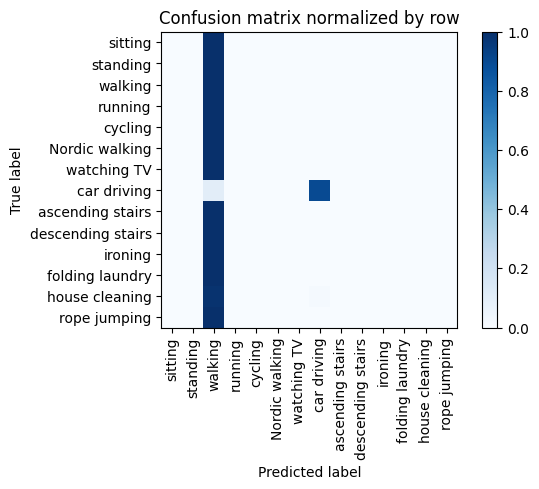

Training Epoch:  80%|████████  | 8/10 [00:25<00:06,  3.26s/it]

Overall accuracy: 0.160



eval: 100%|██████████| 24/24 [00:00<00:00, 60.52batch/s, loss=0.0175]


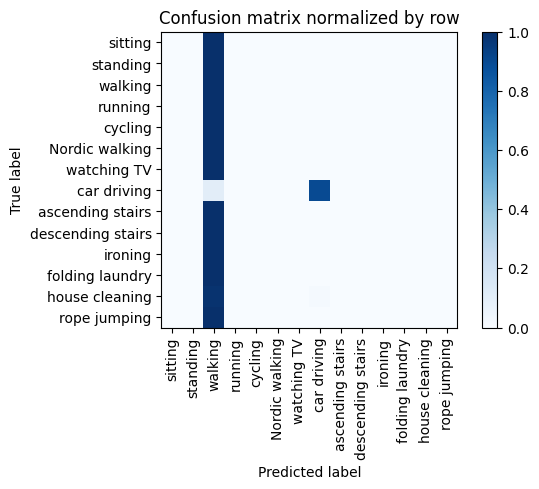

Training Epoch:  90%|█████████ | 9/10 [00:29<00:03,  3.25s/it]

Overall accuracy: 0.160



eval: 100%|██████████| 24/24 [00:00<00:00, 64.06batch/s, loss=0.0192]


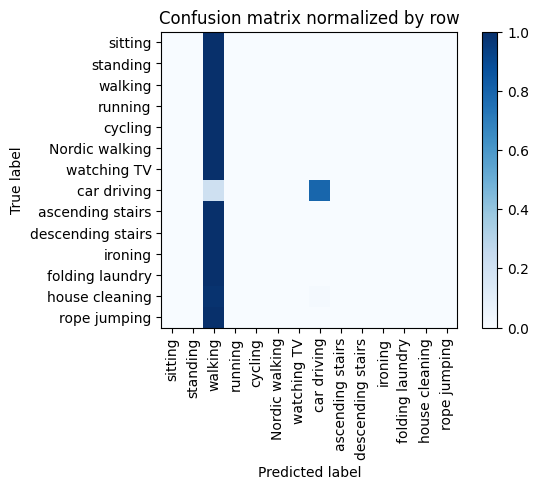

Overall accuracy: 0.157



eval: 100%|██████████| 35/35 [00:00<00:00, 88.38batch/s, loss=0.0404]


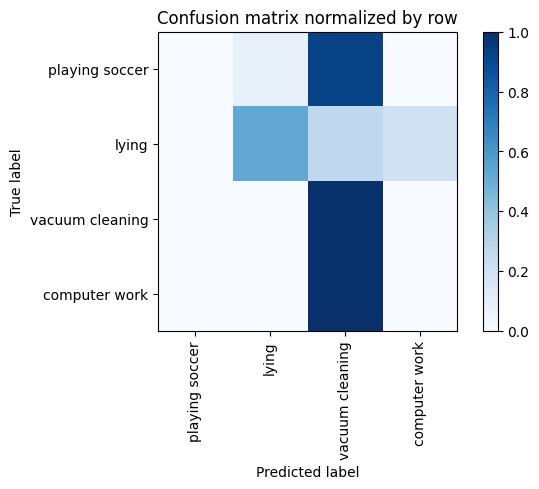

Overall accuracy: 0.376

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

  computer work       0.000      0.000      0.000      0.437        483|	 vacuum cleaning: 1.000,	lying: 0.000,	
vacuum cleaning       0.305      0.996      0.467      0.250        276|	 lying: 0.004,	computer work: 0.000,	
          lying       0.953      0.524      0.676      0.243        269|	 vacuum cleaning: 0.268,	computer work: 0.208,	
 playing soccer       0.000      0.000      0.000      0.070         77|	 vacuum cleaning: 0.922,	lying: 0.078,	computer work: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.308      0.376      0.281        1.0       1105|	      

{'total_accuracy': 0.3764705882352941, 'precision': 0.3144797822239554, 'recall': 0.3801350950918593, 'f1': 0.2858871781079809}
================ Fold-3 ================
Unseen Classes : ['cycling', 'running', 'Nordic walk

eval: 100%|██████████| 27/27 [00:00<00:00, 64.44batch/s, loss=0.0226]


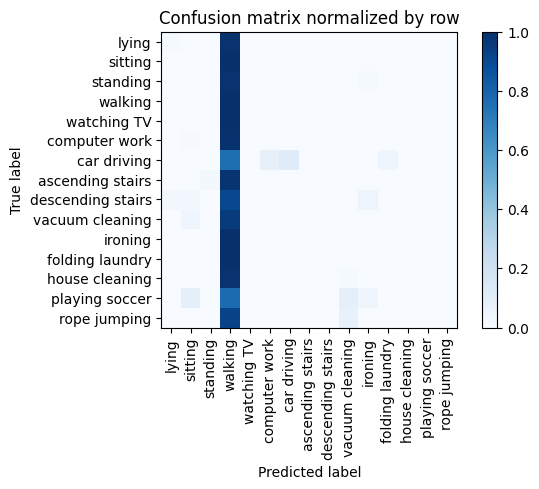

Training Epoch:  10%|█         | 1/10 [00:03<00:33,  3.70s/it]

Overall accuracy: 0.101



eval: 100%|██████████| 27/27 [00:00<00:00, 61.42batch/s, loss=0.0186]


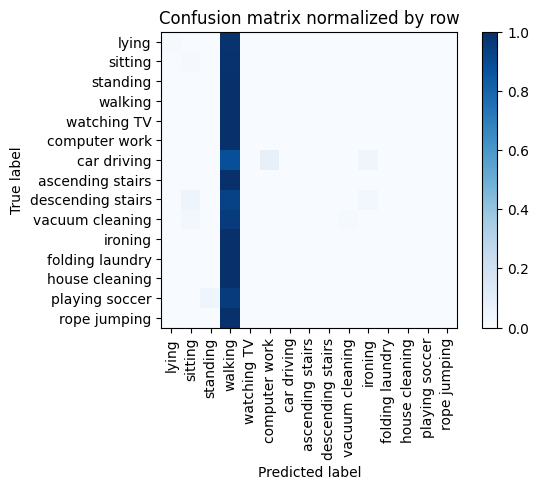

Training Epoch:  20%|██        | 2/10 [00:07<00:28,  3.57s/it]

Overall accuracy: 0.100



eval: 100%|██████████| 27/27 [00:00<00:00, 63.65batch/s, loss=0.0175]


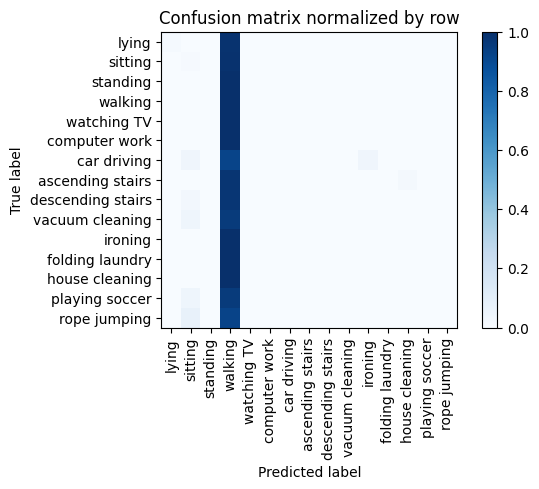

Training Epoch:  30%|███       | 3/10 [00:10<00:24,  3.52s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 27/27 [00:00<00:00, 53.57batch/s, loss=0.0179]


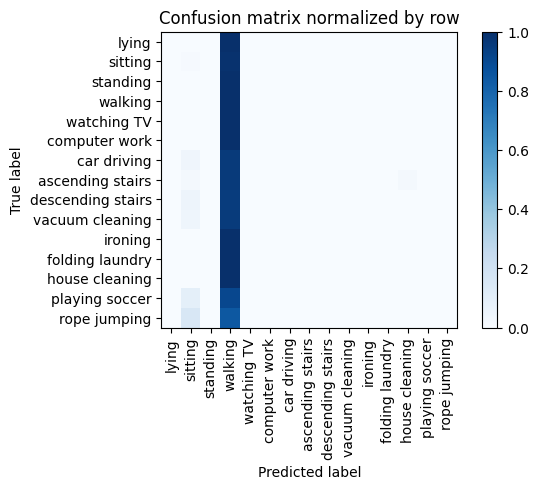

Training Epoch:  40%|████      | 4/10 [00:14<00:21,  3.53s/it]

Overall accuracy: 0.097



eval: 100%|██████████| 27/27 [00:00<00:00, 62.21batch/s, loss=0.0179]


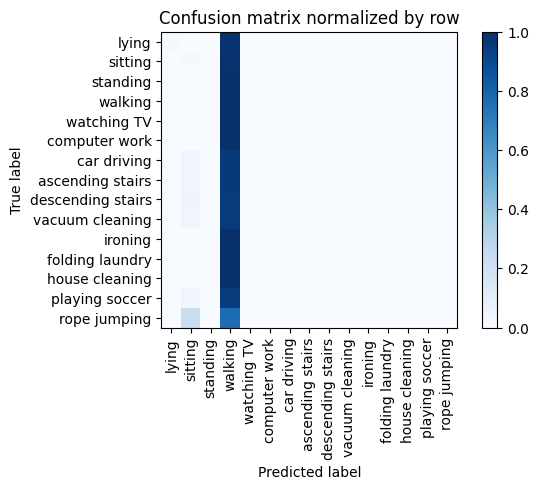

Training Epoch:  50%|█████     | 5/10 [00:17<00:17,  3.52s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 27/27 [00:00<00:00, 61.78batch/s, loss=0.0188]


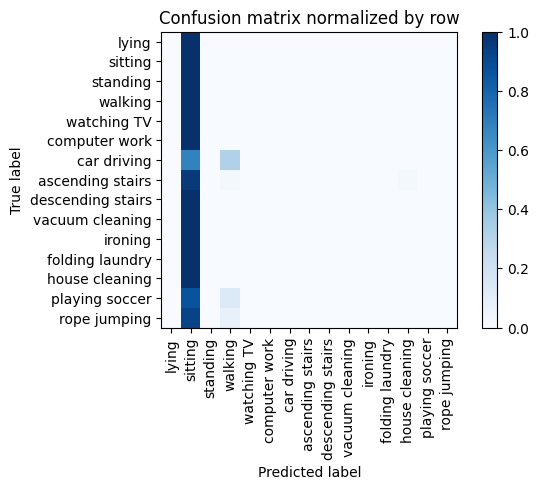

Training Epoch:  60%|██████    | 6/10 [00:21<00:14,  3.55s/it]

Overall accuracy: 0.100



eval: 100%|██████████| 27/27 [00:00<00:00, 63.38batch/s, loss=0.0193]


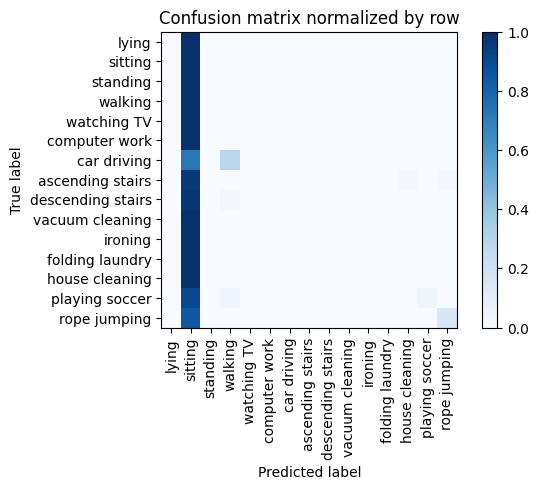

Training Epoch:  70%|███████   | 7/10 [00:24<00:10,  3.57s/it]

Overall accuracy: 0.103



eval: 100%|██████████| 27/27 [00:00<00:00, 50.94batch/s, loss=0.0161]


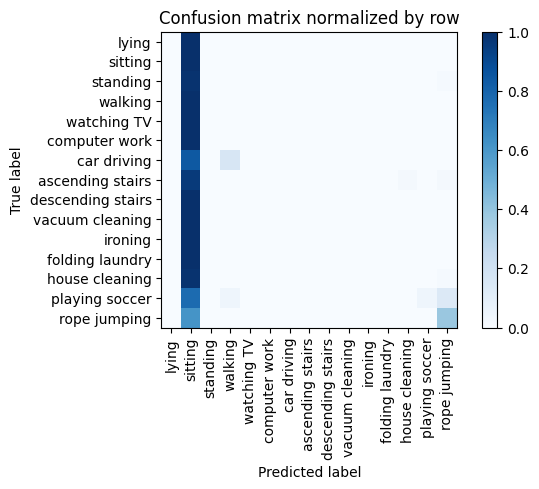

Training Epoch:  80%|████████  | 8/10 [00:28<00:07,  3.62s/it]

Overall accuracy: 0.107



eval: 100%|██████████| 27/27 [00:00<00:00, 61.22batch/s, loss=0.0197]


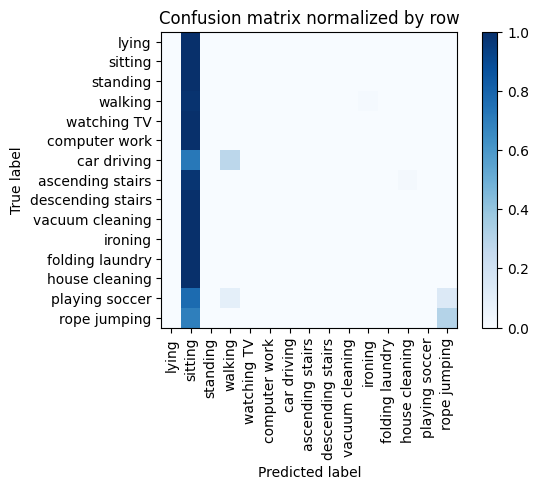

Training Epoch:  90%|█████████ | 9/10 [00:32<00:03,  3.63s/it]

Overall accuracy: 0.104



eval: 100%|██████████| 27/27 [00:00<00:00, 56.96batch/s, loss=0.0171]


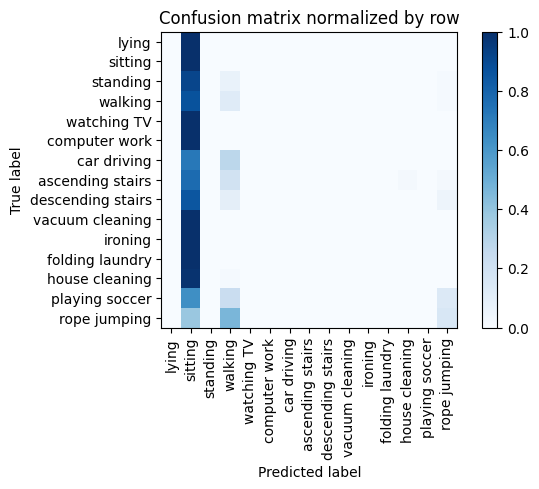

Overall accuracy: 0.114



eval: 100%|██████████| 22/22 [00:00<00:00, 80.00batch/s, loss=0.0282]


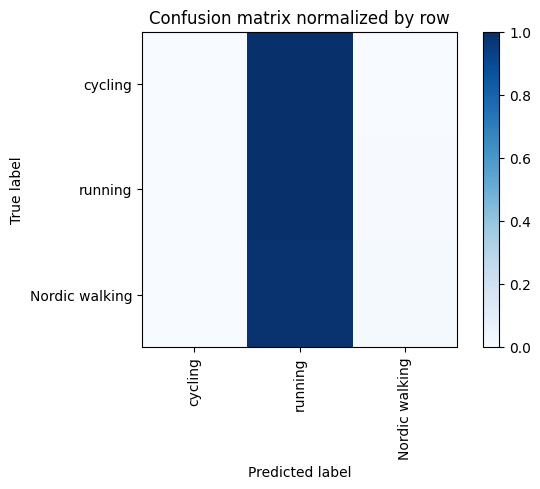

Overall accuracy: 0.222

                 precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

Nordic walking       0.800      0.014      0.027      0.425        291|	 running: 0.986,	cycling: 0.000,	
       cycling       0.000      0.000      0.000      0.358        245|	 running: 1.000,	Nordic walking: 0.000,	
       running       0.218      0.993      0.357      0.218        149|	 Nordic walking: 0.007,	cycling: 0.000,	

----------------------------------------------------------------------------------------------------
   avg / total       0.387      0.222      0.089        1.0        685|	      

{'total_accuracy': 0.22189781021897811, 'precision': 0.33921568627450976, 'recall': 0.335678098357127, 'f1': 0.12802790728001825}
================ Fold-4 ================
Unseen Classes : ['ironing', 'car driving', 'folding laundry']


eval: 100%|██████████| 28/28 [00:00<00:00, 61.65batch/s, loss=0.0229]


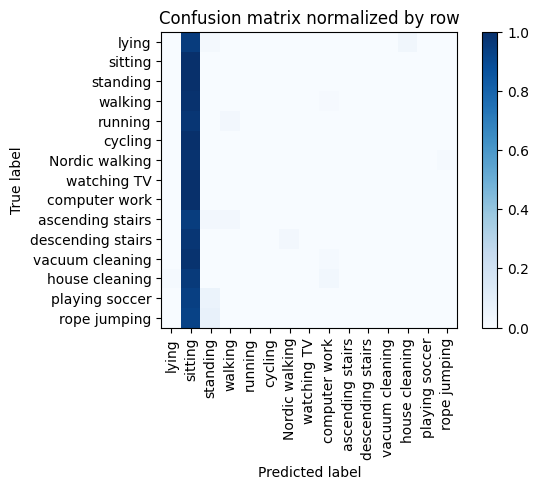

Training Epoch:  10%|█         | 1/10 [00:03<00:33,  3.72s/it]

Overall accuracy: 0.086



eval: 100%|██████████| 28/28 [00:00<00:00, 59.32batch/s, loss=0.0187]


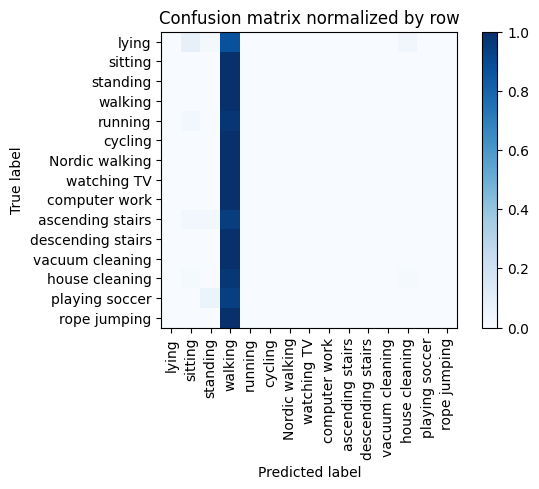

Training Epoch:  20%|██        | 2/10 [00:07<00:29,  3.75s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 28/28 [00:00<00:00, 60.87batch/s, loss=0.0222]


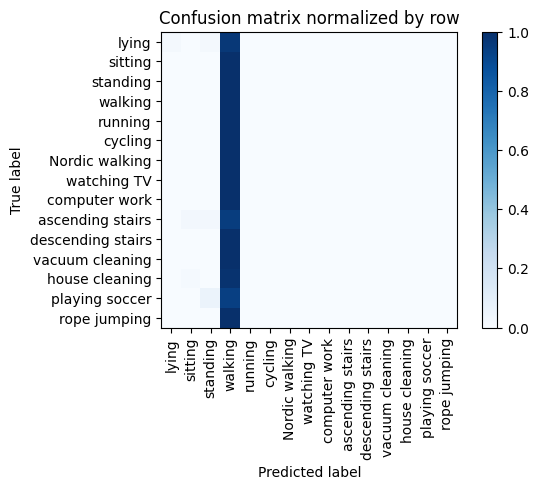

Training Epoch:  30%|███       | 3/10 [00:11<00:25,  3.69s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 28/28 [00:00<00:00, 55.67batch/s, loss=0.018]


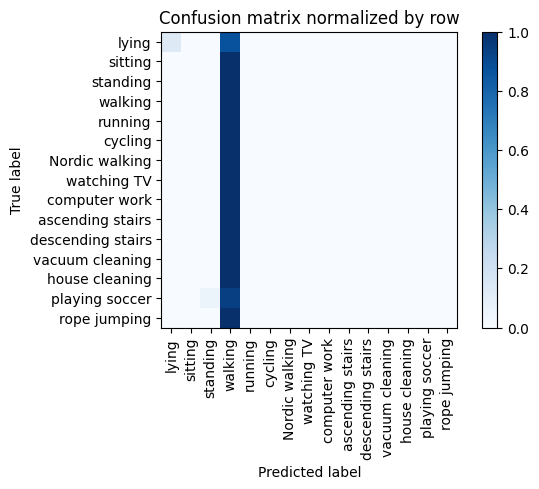

Training Epoch:  40%|████      | 4/10 [00:14<00:22,  3.71s/it]

Overall accuracy: 0.106



eval: 100%|██████████| 28/28 [00:00<00:00, 61.85batch/s, loss=0.0217]


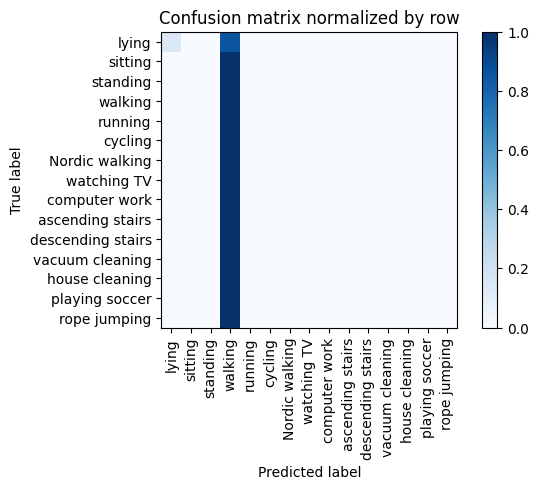

Training Epoch:  50%|█████     | 5/10 [00:18<00:18,  3.71s/it]

Overall accuracy: 0.107



eval: 100%|██████████| 28/28 [00:00<00:00, 62.97batch/s, loss=0.0166]


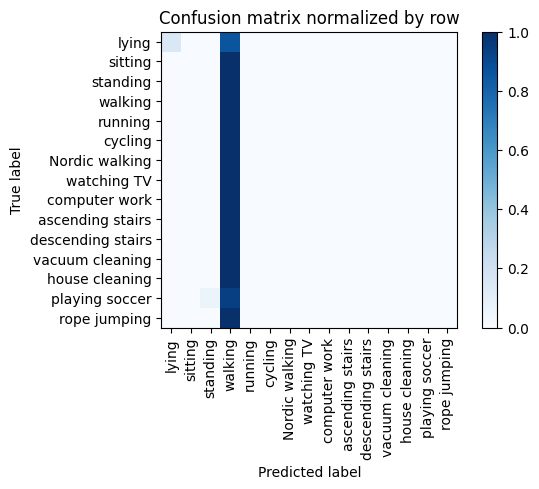

Training Epoch:  60%|██████    | 6/10 [00:22<00:14,  3.73s/it]

Overall accuracy: 0.107



eval: 100%|██████████| 28/28 [00:00<00:00, 61.89batch/s, loss=0.0183]


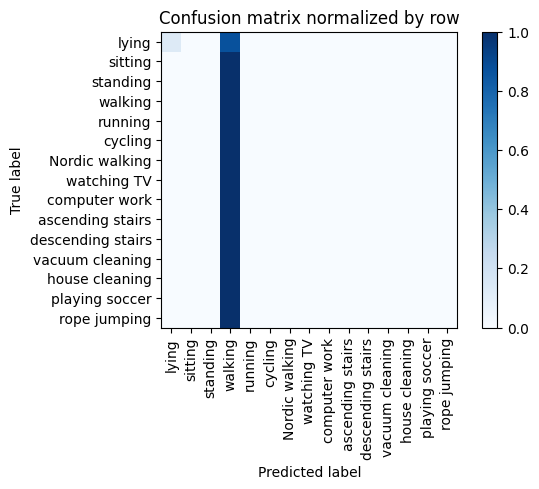

Training Epoch:  70%|███████   | 7/10 [00:26<00:11,  3.72s/it]

Overall accuracy: 0.106



eval: 100%|██████████| 28/28 [00:00<00:00, 62.78batch/s, loss=0.0169]


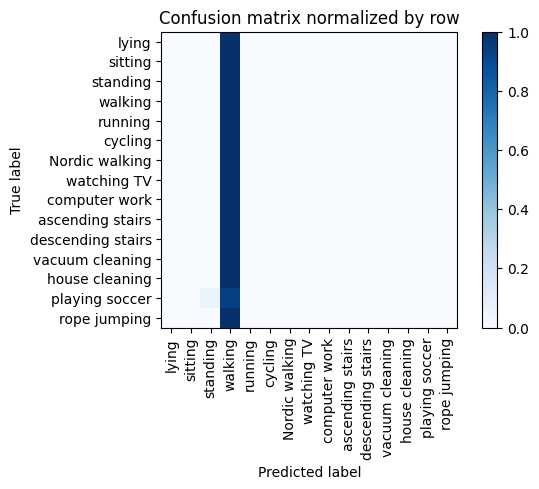

Training Epoch:  80%|████████  | 8/10 [00:29<00:07,  3.75s/it]

Overall accuracy: 0.097



eval: 100%|██████████| 28/28 [00:00<00:00, 62.92batch/s, loss=0.0204]


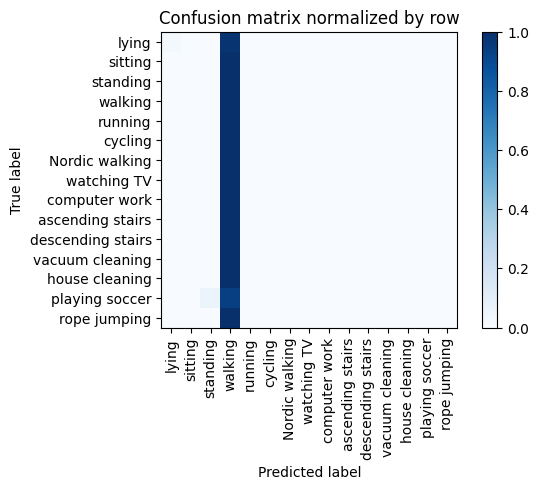

Training Epoch:  90%|█████████ | 9/10 [00:33<00:03,  3.71s/it]

Overall accuracy: 0.098



eval: 100%|██████████| 28/28 [00:00<00:00, 62.82batch/s, loss=0.0178]


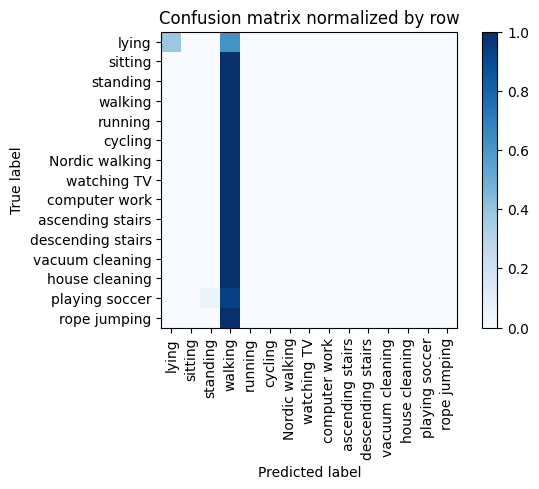

Overall accuracy: 0.124



eval: 100%|██████████| 19/19 [00:00<00:00, 85.77batch/s, loss=0.0631]


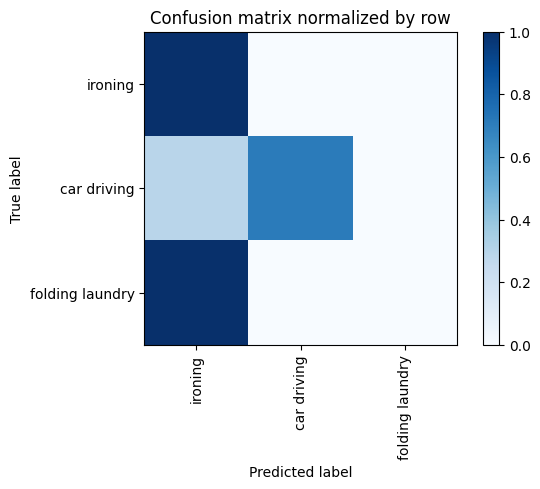

Overall accuracy: 0.708

                  precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

        ironing       0.679      1.000      0.809      0.618        370|	 folding laundry: 0.000,	car driving: 0.000,	
folding laundry       0.000      0.000      0.000      0.255        153|	 ironing: 1.000,	car driving: 0.000,	
    car driving       1.000      0.711      0.831      0.127         76|	 ironing: 0.289,	folding laundry: 0.000,	

----------------------------------------------------------------------------------------------------
    avg / total       0.546      0.708      0.605 0.9999999999999999        599|	      

{'total_accuracy': 0.7078464106844741, 'precision': 0.5596330275229358, 'recall': 0.5701754385964912, 'f1': 0.5465041333893793}
============== Overall Unseen Classes Performance ==============


total_accuracy    0.409021
precision         0.279884
recall            0.355794
f1                0.245953
dtype: float64

In [9]:
fold_metric_scores = []
for i, cs in enumerate(fold_cls_ids):
    print("="*16, f'Fold-{i}', "="*16)
    print(f'Unseen Classes : {fold_classes[i]}')
    # separate seen/unseen and train/eval 
    data_dict = dataReader.generate(unseen_classes=cs, resampling=True, seen_ratio=config['seen_split'], unseen_ratio=config['unseen_split'], window_size=5.21, window_overlap=1, resample_freq=20)
    all_classes = dataReader.idToLabel
    seen_classes = data_dict['seen_classes']
    unseen_classes = data_dict['unseen_classes']
    # print("seen classes > ", seen_classes)
    # print("unseen classes > ", unseen_classes)
    train_n, seq_len, in_ft = data_dict['train']['X'].shape
    # build train_dt 
    # print(seen_classes)
    train_dt = PAMAP2Dataset(data=data_dict['train']['X'], actions=data_dict['train']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    train_dl = DataLoader(train_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build seen eval_dt 
    eval_dt = PAMAP2Dataset(data=data_dict['eval-seen']['X'], actions=data_dict['eval-seen']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=seen_classes)
    eval_dl = DataLoader(eval_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    # build unseen test_dt
    test_dt = PAMAP2Dataset(data=data_dict['test']['X'], actions=data_dict['test']['y'], attributes=attr_mat, action_feats=feat_mat, action_classes=unseen_classes)
    test_dl = DataLoader(test_dt, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
    
    # build model
    model = Model6(in_ft=in_ft, d_model=config['d_model'], num_heads=config['num_heads'], ft_size=feat_size, max_len=seq_len)
    # model = Model1(feat_dim=in_ft, max_len=seq_len, d_model=config['d_model'], n_heads=config['num_heads'], num_layers=2, dim_feedforward=128, ft_size=feat_size)
    model.to(device)
    # define run parameters 
    optimizer = Adam(model.parameters(), lr=config['lr'])
    loss_module = {'feature': MSELoss(), 'attribute': AttributeLoss()}
    best_acc = 0.0
    # train the model 
    for epoch in tqdm(range(config['n_epochs']), desc='Training Epoch', leave=False):
        train_metrics = train_step(model, train_dl, optimizer, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes], target_feat_met=train_dt.target_feat, phase='train', with_attr=False)
        eval_metrics = eval_step(model, eval_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in seen_classes],  target_feat_met=eval_dt.target_feat, phase='eval', with_attrs=False, print_report=False)
        # print(f"EPOCH [{epoch}] TRAINING : {train_metrics}")
        # print(f"EPOCH [{epoch}] EVAL : {eval_metrics}")
        if eval_metrics['total_accuracy'] > best_acc:
            best_model = deepcopy(model.state_dict())
    
    if best_acc == 0.0:
        best_model = deepcopy(model.state_dict())
    
    # replace by best model 
    model.load_state_dict(best_model)

    # run evaluation on unseen classes
    test_metrics = eval_step(model, test_dl, loss_module, 0.7, device, class_names=[all_classes[i] for i in unseen_classes],  target_feat_met=test_dt.target_feat, phase='eval', with_attrs=False)
    fold_metric_scores.append(test_metrics)
    print(test_metrics)
    print("="*40)
print("="*14, "Overall Unseen Classes Performance", "="*14)
seen_score_df = pd.DataFrame.from_records(fold_metric_scores)
seen_score_df.mean()
    